In [11]:
import pandas as pd

csv = './data/spotify.csv'
data = pd.read_csv(csv)
df_spotify = pd.DataFrame(data)
print(df_spotify.head(1))

                 track_id                                         track_name  \
0  6f807x0ima9a1j3VPbc7VN  I Don't Care (with Justin Bieber) - Loud Luxur...   

  track_artist  track_popularity          track_album_id  \
0   Ed Sheeran                66  2oCs0DGTsRO98Gh5ZSl2Cx   

                                    track_album_name track_album_release_date  \
0  I Don't Care (with Justin Bieber) [Loud Luxury...               2019-06-14   

  playlist_name             playlist_id playlist_genre  ... key  loudness  \
0     Pop Remix  37i9dQZF1DXcZDD7cfEKhW            pop  ...   6    -2.634   

   mode  speechiness  acousticness  instrumentalness  liveness  valence  \
0     1       0.0583         0.102               0.0    0.0653    0.518   

     tempo  duration_ms  
0  122.036       194754  

[1 rows x 23 columns]


In [27]:
dato = df_spotify.loc[52]
dato

track_id                         3kgKVcBpBGuSeaEC0AZGlb
track_name                  Old Town Road - Diplo Remix
track_artist                                  Lil Nas X
track_popularity                                     74
track_album_id                   66FxETmTBazRMZNbvGtGQl
track_album_name            Old Town Road (Diplo Remix)
track_album_release_date                     2019-04-29
playlist_name                                 Pop Remix
playlist_id                      37i9dQZF1DXcZDD7cfEKhW
playlist_genre                                      pop
playlist_subgenre                             dance pop
danceability                                      0.766
energy                                            0.771
key                                                   6
loudness                                         -9.108
mode                                                  1
speechiness                                      0.0576
acousticness                                    

In [23]:
dato = df_spotify.iloc[0:2]
dato

,track_id,track_name,track_artist,track_popularity,track_album_id,track_album_name,track_album_release_date,playlist_name,playlist_id,playlist_genre,...,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,6f807x0ima9a1j3VPbc7VN,I Don't Care (with Justin Bieber) - Loud Luxur...,Ed Sheeran,66,2oCs0DGTsRO98Gh5ZSl2Cx,I Don't Care (with Justin Bieber) [Loud Luxury...,2019-06-14,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,6,-2.634,1,0.0583,0.1020,0.00000,0.0653,0.518,122.036,194754
1,0r7CVbZTWZgbTCYdfa2P31,Memories - Dillon Francis Remix,Maroon 5,67,63rPSO264uRjW1X5E6cWv6,Memories (Dillon Francis Remix),2019-12-13,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,11,-4.969,1,0.0373,0.0724,0.00421,0.3570,0.693,99.972,162600


In [14]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import GroupShuffleSplit

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks


X = df_spotify.copy().dropna()
y = X.pop('track_popularity')
artists = X['track_artist']

features_num = ['danceability', 'energy', 'key', 'loudness', 'mode',
                'speechiness', 'acousticness', 'instrumentalness',
                'liveness', 'valence', 'tempo', 'duration_ms']
features_cat = ['playlist_genre']

preprocessor = make_column_transformer(
    (StandardScaler(), features_num),
    (OneHotEncoder(), features_cat),
)

def group_split(X, y, group, train_size=0.75):
    splitter = GroupShuffleSplit(train_size=train_size)
    train, test = next(splitter.split(X, y, groups=group))
    return (X.iloc[train], X.iloc[test], y.iloc[train], y.iloc[test])

X_train, X_valid, y_train, y_valid = group_split(X, y, artists)

X_train = preprocessor.fit_transform(X_train)
X_valid = preprocessor.transform(X_valid)
y_train = y_train / 100
y_valid = y_valid / 100

input_shape = [X_train.shape[1]]
print("Input shape: {}".format(input_shape))

Input shape: [18]


In [15]:

model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=input_shape),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1)
])


Minimum Validation Loss: 0.1864


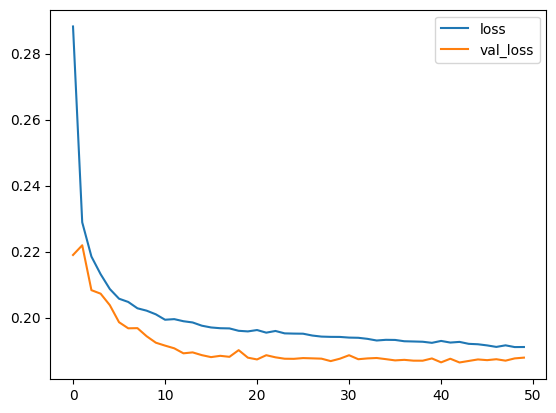

In [16]:
model.compile(
    optimizer='adam',
    loss='mae',
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=50,
    verbose=0,
)
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()))

In [17]:
import pickle

# guarda model y preprocessor en un archivo pickle en formato binario como un array de dos elementos
with open('./models/spotify.pkl', 'wb') as model_file:
    pickle.dump((model, preprocessor), model_file)


In [18]:
preprocessor.get_feature_names_out()

array(['standardscaler__danceability', 'standardscaler__energy',
       'standardscaler__key', 'standardscaler__loudness',
       'standardscaler__mode', 'standardscaler__speechiness',
       'standardscaler__acousticness', 'standardscaler__instrumentalness',
       'standardscaler__liveness', 'standardscaler__valence',
       'standardscaler__tempo', 'standardscaler__duration_ms',
       'onehotencoder__playlist_genre_edm',
       'onehotencoder__playlist_genre_latin',
       'onehotencoder__playlist_genre_pop',
       'onehotencoder__playlist_genre_r&b',
       'onehotencoder__playlist_genre_rap',
       'onehotencoder__playlist_genre_rock'], dtype=object)